## Notebook showing an implementation of our multilayer community detection method on gene co-expression data 

The data used in this notebook is gene expression (TPM) data from the GTEx portal, release V8. We will analyze data from 203 genes in four exocrine glands: pancreas, minor salivary gland, mammary gland, and skin (not sun exposed).

In [2]:
#importing libraries

%matplotlib inline
import numpy as np
import numpy.matlib
import configcorr as cg #for correlation matrix null model
from scipy.sparse import spdiags
import pandas as pd
import matplotlib.pyplot as plt
from netneurotools import cluster #for consensus clustering
import matlab.engine #for GenLouvain

import corr_comm_detection as ccd #access my community detection functions

In [4]:
#access empirical covariance matrices that I saved as a 3D numpy array
#these covariance matrices quanify the co-expression of 203 genes in four different organs
p = np.load('/Users/madisonrussell/Desktop/code_for_Github/exo_emp_covs.npy',
              allow_pickle=True)

#access array of omegas (strengths of interlayer couplings) that I saved as a 3D numpy array
#these values were determined by the Pearson correlation of a gene between two organs
emp_omegas = np.load('/Users/madisonrussell/Desktop/code_for_Github/organ_corr_omegas.npy',
                     allow_pickle=True)

#run the community detection code (in corr_comm_detection.py) to obtain the parition and significance results
gene_part_array, zscores = ccd.main(p,L=100,
    genlouvain_file_location='/Users/madisonrussell/Desktop/gene_networks_code/GenLouvain-master',
    tolerance=1e-5,runs=200,gamma=3.0,omega=emp_omegas)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Feb 22 07:39:08 PM: Your problem has 41209 variables, 2 constraints, and 0 parameters.
(CVXPY) Feb 22 07:39:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 22 07:39:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 22 07:39:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 22 07:39:08 PM: Compiling problem (target solver=SCS).
(CVXPY) Feb 22 07:39:08 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

(CVXPY) Feb 22 07:40:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Feb 22 07:40:18 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 22 07:40:18 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 22 07:40:18 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 22 07:40:18 PM: Applying reduction SCS
(CVXPY) Feb 22 07:40:18 PM: Finished problem compilation (took 4.395e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Feb 22 07:40:18 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 41615, constraints

In [5]:
#print the Z score for each community detected
print(zscores)

[35.13194461637364, 47.721339170427335, 29.81735768724844, 12.325040214945775, 79.03101701280023, 27.4711980186015, 5.793767904865582, 4.407833676826586, 7.588803322690636, 'N/A', 'N/A', 'N/A']


The z-scores indicate that the first 9 out of 12 total communities detected are statistically significant.

#### Functions to process the gene co-expression network partition and visualize the composition of the communities as a stacked bar chart

In [11]:
def process_partition(partition,tpm_dfs,organ_labels):
    """
    function to process partition results and output dataframe for bar chart
    input: partition: partition of the network.
                      2D numpy array describing the partition found by iterated genlouvain,
                      dimensions are number of nodes in each layer x number of layers
                      rows represent variables, columns represent layers,
                      entries represent community assignment of that node
           tpm_dfs: dataframe with raw TPM data used to generate the network
           organ_labels: list of strings with each organ (layer) in the network
    output: df: results dataframe with columns gene_id, organ_layer, community, overlapped
            num_genes:
    """
    
    #number of layers
    num_layers = len(tpm_dfs)
    #number of nodes in each layer
    num_nodes = len(partition)
    #number of communities
    num_comms = int(np.amax(partition))
    
    #make a dataframe with columns gene_id, organ_layer, community
    #same set of genes in same order in each dataframe, so doesn't matter which one we pull gene ids from
    gene_ids = list(tpm_dfs[0]['Name'])
    
    #function to remove version number from each gene in list
    def remove_ver(gene_list):
        new_list = []
        for i in range(len(gene_list)):
            new_list.append(gene_list[i][:15]) #just take first 15 characters of gene id
        return new_list
    
    gene_ids_nov = remove_ver(gene_ids)
    
    #list of gene ids for entire multilayer gene network for gene_id column of the dataframe
    all_gene_ids = []
    for i in range(num_layers):
        all_gene_ids += gene_ids_nov
        
    #list of organ label for organ_layer column of dataframe
    organ_layer = []
    for j in range(num_layers):
        for i in range(num_nodes):
            organ_layer.append(organ_labels[j])
            
    #make flat list of community assignments for community column of the dataframe
    comm = []
    for j in range(num_layers):
        for i in range(num_nodes):
            comm.append(int(partition[i][j]))
    
    #make dataframe with results
    data = {'gene_id': all_gene_ids, 'organ_layer': organ_layer, 'community': comm}
    df = pd.DataFrame(data=data)
    
    #add column to dataframe indicating overlapping genes
    dfbool = df.duplicated(keep=False,subset=['gene_id','community']).tolist()
    df['overlapped'] = dfbool
    
    #for visualizing genlouvain results
    #get count of number of genes from each organ for each module
    num_genes = np.zeros((num_layers,num_comms)) #row = organ, column = module
    
    for k in range(num_layers):
        for i in range(num_comms):
            count = 0
            for j in range(num_nodes*num_layers):
                if df.organ_layer[j] == organ_labels[k]:
                    if df.community[j] == i+1:
                        count += 1
            num_genes[k][i] = count
    
    return df, num_genes


def stacked_bar_chart(partition_df,colormap,fig_name='GenLouvain_bar_chart.png'):
    """
    function to visualize multilayer community results as a stacked bar chart
    input: partition_df: results dataframe with columns gene_id, organ_layer, community, overlapped
           colormap: matplotlib colormap name
           fig_name: file name for figure created (put .png at the end)
    output: plots a stacked bar chart, saves figure
    """
    
    num_comms = partition_df['community'].max()
    organs = partition_df.organ_layer.unique()
    num_organs = len(organs)
    #get columns for dataframe: pancreas genes, pancreas only genes, salivary genes, salivary only genes,...
    columns = []
    for o in organs:
        overlapped = []
        unique = []
        for i in range(1,num_comms+1):
            subdf = partition_df[(partition_df['organ_layer']==str(o))&(partition_df['community']==i)]
            count_overlap = len(subdf[subdf['overlapped']==True])
            count_unique = len(subdf[subdf['overlapped']==False])
            overlapped.append(count_overlap)
            unique.append(count_unique)
        columns.append(unique)
        columns.append(overlapped) 
    
    d = {'Community': list(range(1,num_comms+1))}
    for i in range(num_organs):
        organ = organs[i]
        d.update({str(organ)+' only': columns[i*2]})
        d.update({str(organ)+' other': columns[(i*2)+1]})
    chart_df = pd.DataFrame(data=d)
               
    chart_df.plot(x='Community', kind='bar', stacked=True, colormap=colormap, fontsize=30,
                  figsize=(15,7), ylabel='Number of nodes', rot=0, legend='reverse')
    plt.xlabel('Community',fontsize=30)
    plt.ylabel('Number of nodes',fontsize=30)
    plt.rc('legend',fontsize=30)
    plt.savefig(str(fig_name), dpi=300, bbox_inches='tight')
    plt.show()

### Visualizing our results

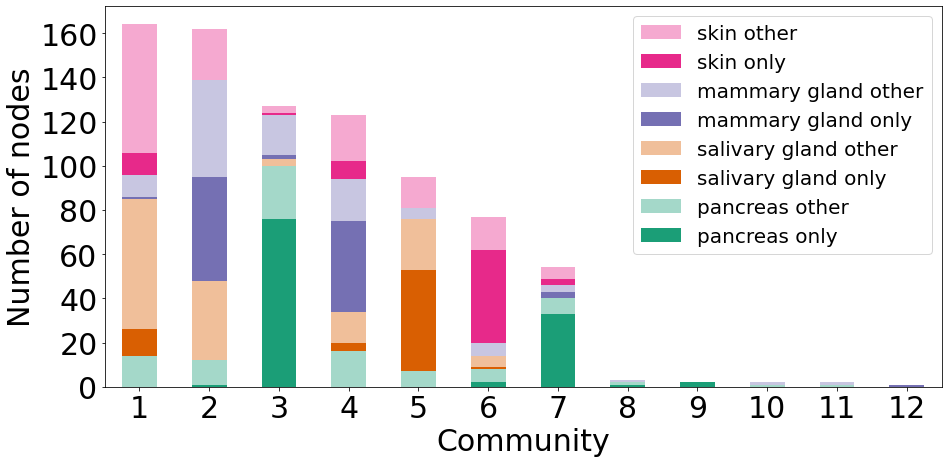

In [12]:
#accessing dataframe with raw tpm data used to generate this network
%store -r tpm_dfs
#accessing colormap I made
%store -r dark2tints_cmap

gene_part_df, num_genes = process_partition(gene_part_array,tpm_dfs,
                                           organ_labels=['pancreas','salivary gland','mammary gland','skin'])
stacked_bar_chart(gene_part_df,colormap=dark2tints_cmap,fig_name='results_bar_chart.png')